In [606]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np
import yaml
import os

seed=456

In [607]:
##  Extracting data
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

output_path = config["output"]["path"]

train_df = pd.read_csv(config["data"]["processed_train_path"])
test_df = pd.read_csv(config["data"]["processed_test_path"])

# Define our features (X) and target (y)
features = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]



X_train = train_df[features]
X_test=test_df[features]
y_train = train_df['player_won']
#print(features)

X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train,train_size=.8, shuffle=True, random_state=seed)

In [608]:
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_vali=scaler.transform(X_vali)
X_test = scaler.transform(X_test)
print("(number of data, number of features):",X_train.shape)

(number of data, number of features): (7999, 89)


# Data visualization


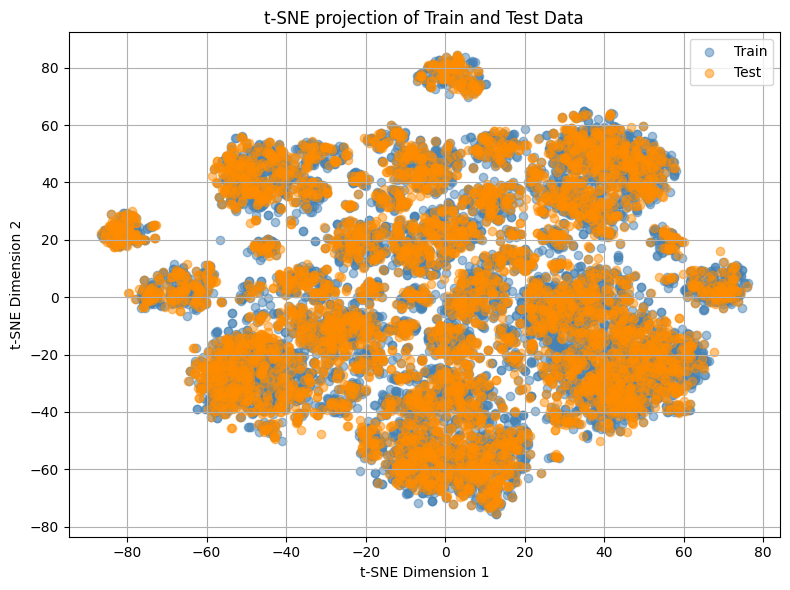

In [609]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE



# combining data
X_combined = np.vstack((X_train, X_test))

# Tsne run
tsne = TSNE(
    n_components=2,
    perplexity=30,          
    learning_rate='auto',
    init='pca',
    random_state=seed,
    verbose=False
)

X_combined_tsne = tsne.fit_transform(X_combined)

# Split back into train/test embeddings
X_train_tsne = X_combined_tsne[:len(X_train)]
X_test_tsne = X_combined_tsne[len(X_train):]

# --- Step 4: 2D scatter plot ---
plt.figure(figsize=(8, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1],
            alpha=0.5, label='Train', color='steelblue')
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1],
            alpha=0.5, label='Test', color='darkorange')

plt.title("t-SNE projection of Train and Test Data")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Logistic Regression

In [610]:
## GRID SEARCH
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Scaling all the data


model = LogisticRegression(random_state=seed)

param_grid = {
    'C': [0.5, 1, 2, 10], 
    'penalty': ['l1','l2'],
    'solver': ['liblinear'],
    'max_iter': [10000]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score= True
)

grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")


best_logreg = grid_search.best_estimator_
best_param_lr = grid_search.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
 Best model mean validation accuracy: 0.8286
 Standard deviation across validation folds: 0.0051
Best hyperparameters found: {'C': 1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy in CV: 0.8286


In [611]:
## TRAINING IN THE TRAINING SET
logreg=LogisticRegression(**best_param_lr,random_state=seed)
logreg.fit(X_train,y_train)
y_pred= logreg.predict(X_vali)
logreg_accuracy = accuracy_score(y_vali,y_pred)
print("acc",logreg_accuracy)
best_logreg=logreg

acc 0.83


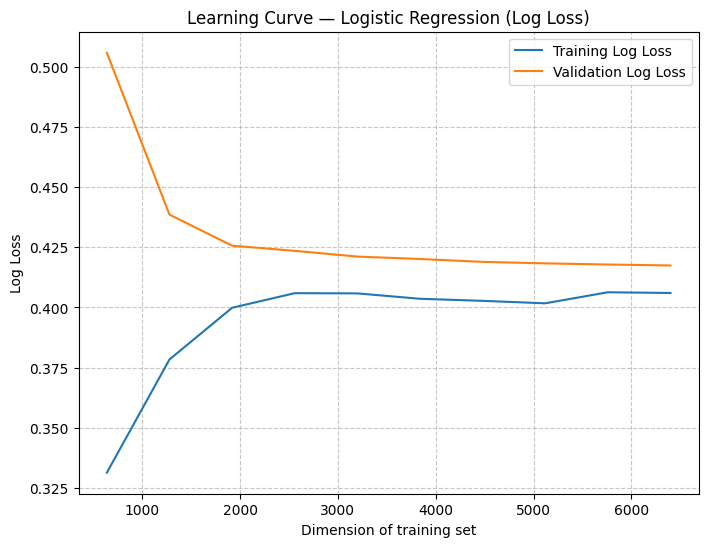

In [612]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(
    logreg, X_train, y_train,
    cv=5,
    scoring='neg_log_loss',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=seed,
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, -train_mean, label='Training Log Loss') 
plt.plot(train_sizes, -val_mean, label='Validation Log Loss')
plt.xlabel('Dimension of training set')
plt.ylabel('Log Loss') 
plt.title('Learning Curve — Logistic Regression (Log Loss)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## KNN

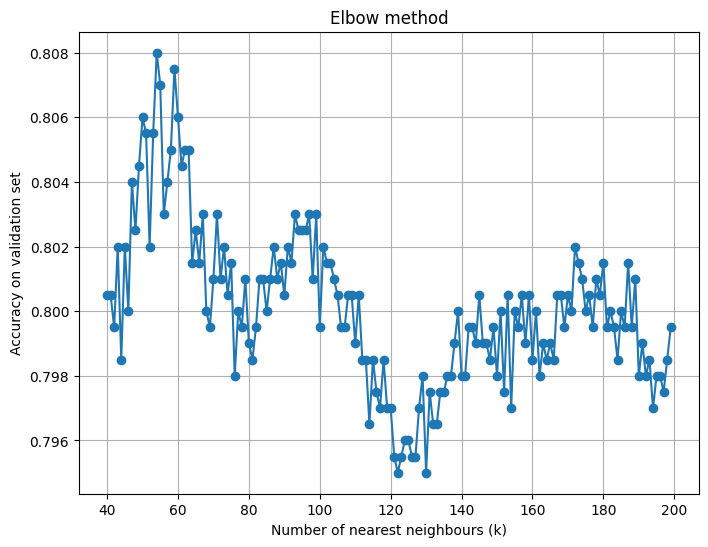

Best k: 54
Accuracy for validation set: 0.8080
 Best model mean validation accuracy: 0.7999
 Standard deviation across validation folds: 0.0078
Best hyperparameters found: {'metric': 'manhattan', 'n_neighbors': 54, 'weights': 'uniform'}
Best accuracy in CV: 0.7999


In [613]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score


model = KNeighborsClassifier()

k_values = list(range(40,200))
accuracies=[]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_vali)
    acc = accuracy_score(y_vali, y_pred)
    accuracies.append(acc)


plt.figure(figsize=(8,6))
plt.plot(k_values, accuracies, marker='o')
plt.title("Elbow method")
plt.xlabel("Number of nearest neighbours (k)")
plt.ylabel("Accuracy on validation set")
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(accuracies)]
print(f"Best k: {best_k}")
print(f"Accuracy for validation set: {max(accuracies):.4f}")

param_grid = {
    'n_neighbors': [best_k],           
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski','manhattan', 'euclidean'],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=False,
)


grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")


best_knn = grid_search.best_estimator_
best_param_knn = grid_search.best_params_

In [614]:
### This is the total knn classifier

best_knn = KNeighborsClassifier(**best_param_knn)
best_knn.fit(X_train, y_train)
y_pred= best_knn.predict(X_vali)
knn_accuracy = accuracy_score(y_vali,y_pred)
print("acc", knn_accuracy)

acc 0.8065


# DECISION TREES


In [615]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score


# No need to scale the data

model = DecisionTreeClassifier(random_state=seed)

k_range = list(range(60,200,20))

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'], # impurity function to minimize
    'max_depth': [5,6,7,8], # max_depth of the tree
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3,
    return_train_score= True
)

grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")


best_dt = grid_search.best_estimator_
best_param_dt = grid_search.best_params_


Fitting 5 folds for each of 12 candidates, totalling 60 fits
 Best model mean validation accuracy: 0.7922
 Standard deviation across validation folds: 0.0079
Best hyperparameters found: {'criterion': 'gini', 'max_depth': 5}
Best accuracy in CV: 0.7922


acc 0.796


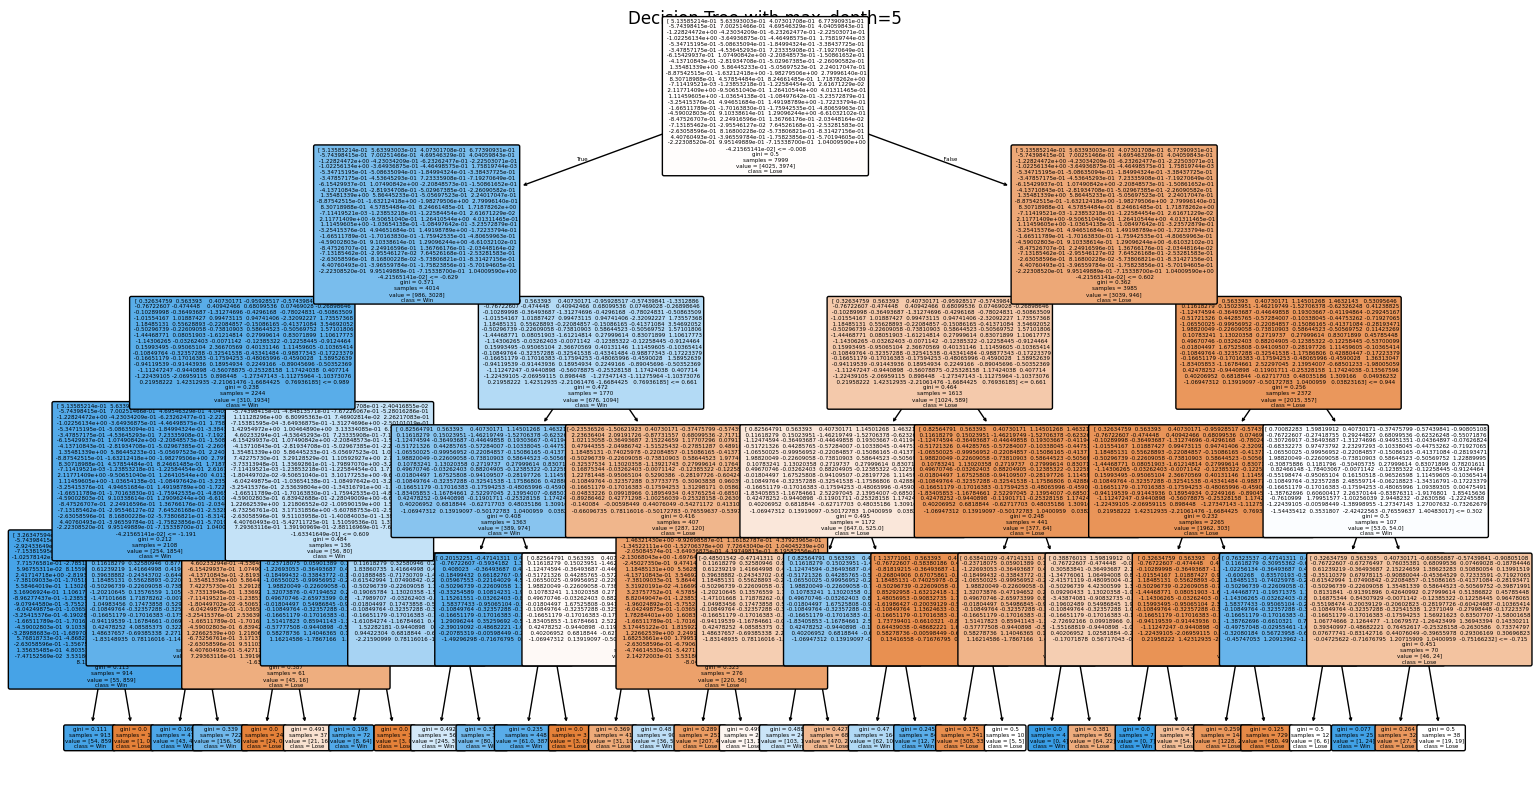

In [616]:
best_dt = DecisionTreeClassifier(**best_param_dt, random_state=seed)
best_dt.fit(X_train, y_train)
y_pred= best_dt.predict(X_vali)
dt_accuracy = accuracy_score(y_vali,y_pred)
print("acc",dt_accuracy)
plt.figure(figsize=(18,10))
plot_tree(best_dt,
          feature_names=X_train,
          class_names=['Lose', 'Win'],   
          filled=True,                   
          rounded=True,                  
          fontsize=4)
plt.title(f"Decision Tree with max_depth={best_param_dt['max_depth']}")
plt.show()

# RANDOM FOREST

In [617]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
# Random Forest
rforest = RandomForestClassifier(
    criterion='gini',
    max_depth=10,
    n_estimators=400,
    random_state=seed
)

# K-Fold cross-validation (k=5)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Calcolo dell’accuracy media con cross-validation
scores = cross_val_score(rforest, X_train, y_train, cv=kfold, scoring='accuracy')

print("Accuracy per fold:", np.round(scores, 3))
print(f"Accuracy in mean +- stddev: {scores.mean():.3f} ± {scores.std():.3f}")


Accuracy per fold: [0.811 0.817 0.818 0.818 0.822]
Accuracy in mean +- stddev: 0.817 ± 0.003


In [618]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [400, 500, 600],
    'max_depth': [15, 30, 40, 50],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'max_features': ['sqrt'],
    'criterion': ['entropy']
}

# Initialize the base model
rforest = RandomForestClassifier(random_state=seed)

# Set up K-Fold cross-validation (k=5)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Set up the Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=rforest,
    param_grid=param_grid,
    cv=kfold,
    scoring='accuracy',
    n_jobs=-1,       # use all available CPU cores
    verbose=2
)

# Run the grid search
grid_search.fit(X_train, y_train)

# Results
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")

best_param_rf = grid_search.best_params_


Fitting 5 folds for each of 12 candidates, totalling 60 fits
 Best model mean validation accuracy: 0.8199
 Standard deviation across validation folds: 0.0041
Best hyperparameters found: {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}
Best accuracy in CV: 0.8209


In [619]:
best_rf = RandomForestClassifier(**best_param_rf, random_state=seed)
best_rf.fit(X_train, y_train)
y_pred= best_rf.predict(X_vali)
rf_accuracy = accuracy_score(y_vali,y_pred)
print("acc", rf_accuracy)

acc 0.8255


# XGBOOST


In [620]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, GridSearchCV
import numpy as np
import xgboost as xgb

# Base XGBoost model
xgb = XGBClassifier(
    random_state=seed,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [700, 800, 900],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.02, 0.03],
    'gamma': [0],
    'lambda': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.9]
}

# K-Fold cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=kfold,
    n_jobs=-1,
    verbose=2
)

# Run the grid search
grid_search.fit(X_train, y_train)

# Results
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")
best_param_xgb = grid_search.best_params_


Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\franc\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:25:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Best model mean validation accuracy: 0.8349
 Standard deviation across validation folds: 0.0031
Best hyperparameters found: {'colsample_bytree': 0.9, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.8}
Best accuracy in CV: 0.8349


acc 0.8425


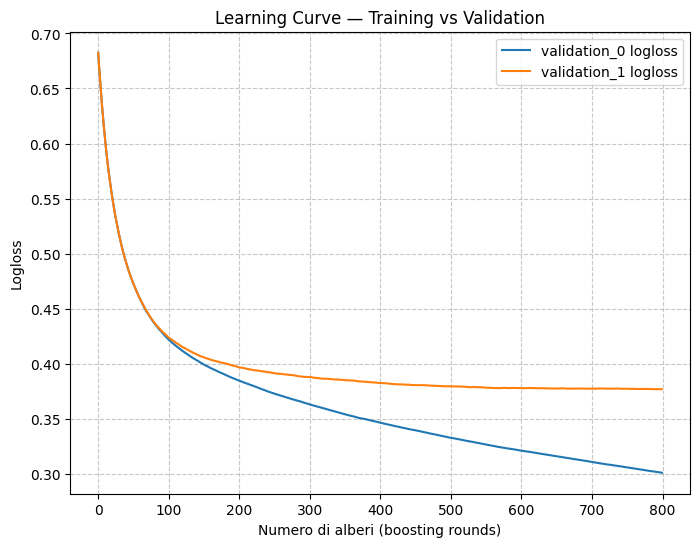

In [621]:
evals_result = {}
best_xgb = XGBClassifier(**best_param_xgb, random_state=seed)
best_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_vali, y_vali)], verbose=False)
y_pred= best_xgb.predict(X_vali)
xgb_accuracy = accuracy_score(y_vali,y_pred)
print(f"acc {xgb_accuracy:.4f}")

evals_result = best_xgb.evals_result()

# 3️⃣ Recupera le curve in modo dinamico
keys = list(evals_result.keys())
train_key, vali_key = keys[0], keys[1]

train_loss = evals_result[train_key]['logloss']
vali_loss = evals_result[vali_key]['logloss']

# Plot loss
plt.figure(figsize=(8,6))
plt.plot(train_loss, label=f'{train_key} logloss')
plt.plot(vali_loss, label=f'{vali_key} logloss')
plt.xlabel('Numero di alberi (boosting rounds)')
plt.ylabel('Logloss')
plt.title('Learning Curve — Training vs Validation')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# ENSEMBLE

In [622]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('logreg', best_logreg),
        ('knn', best_knn)
    ],
    voting='soft'  # or 'hard' if models don’t support predict_proba
)

ensemble.fit(X_train, y_train)

print("Ensemble accuracy:", ensemble.score(X_vali, y_vali))

Ensemble accuracy: 0.838


In [623]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Base learners
estimators = [
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('logreg', best_logreg),
    ('knn', best_knn)
]

# Meta-learner (impara a combinare i modelli)
meta_model = LogisticRegression(random_state=seed, max_iter=100000)

# Stacking ensemble
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=True 
)

stack.fit(X_train, y_train)
stck_accuracy=stack.score(X_vali, y_vali)
print("Stacking accuracy:", stck_accuracy)

Stacking accuracy: 0.8465


## Playing with feature importance

Top 15 most important features:
                 Feature  Importance
0      health_difference    0.093197
1   p1_remain_health_avg    0.045514
2           p1_fnt_count    0.040819
3    remaining_advantage    0.035278
4         p2_total_moves    0.033147
5   p2_remain_health_avg    0.031357
6      p1_status_changes    0.031171
7         p1_mean_hp_pct    0.030782
8         p1_total_moves    0.029074
9      p2_status_changes    0.027169
10          p2_slp_count    0.024278
11          p1_slp_count    0.022184
12        p2_mean_hp_pct    0.018902
13           p2_final_hp    0.015807
14       p2_total_damage    0.015359
Least important 10 features:
                   Feature  Importance
79     p2_substitute_count    0.001219
80     p1_substitute_count    0.001028
81      p2_lead_type_grass    0.000924
82            p1_tox_count    0.000916
83  p1_highcrit_moves_used    0.000807
84            p2_tox_count    0.000786
85     p2_lead_type_normal    0.000675
86   p2_lead_type_electric    0.000

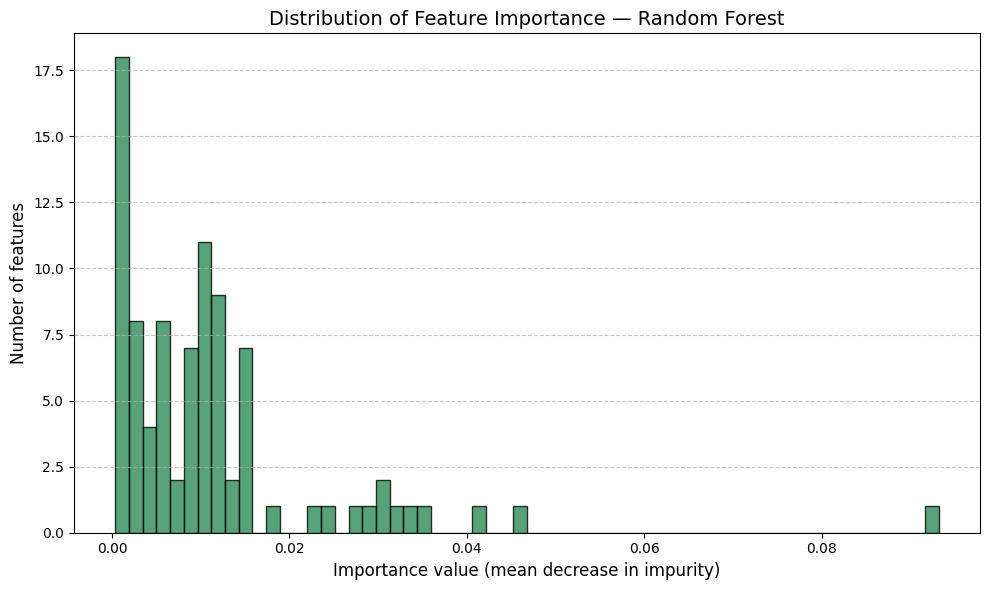

In [624]:
feature_names=[]  ## we put here the features by importance

# We gain the importances
importances = best_rf.feature_importances_


# we create the importance df
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

# we display top and bottom features
print("Top 15 most important features:")
print(importance_df.head(15))
print("Least important 10 features:")
print(importance_df.tail(10))

# hist of feature importance
plt.figure(figsize=(10, 6))
plt.hist(importance_df["Importance"], bins=60, color="seagreen", edgecolor="black", alpha=0.8)
plt.title("Distribution of Feature Importance — Random Forest", fontsize=14)
plt.xlabel("Importance value (mean decrease in impurity)", fontsize=12)
plt.ylabel("Number of features", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
feature_names.append(importance_df['Feature'].tolist())

Metric: weight
Top 15 most important features:
                 Feature  Importance
84     health_difference       266.0
42        p2_total_moves       204.0
47     p1_status_changes       177.0
88   remaining_advantage       160.0
81    p1_defensive_share       156.0
51          p1_fnt_count       152.0
38           p2_final_hp       146.0
41        p1_total_moves       144.0
37           p1_final_hp       139.0
49          p1_slp_count       131.0
40       p2_total_damage       123.0
83  p2_remain_health_avg       118.0
35        p1_mean_hp_pct       113.0
36        p2_mean_hp_pct       112.0
72   p2_effectivness_avg       109.0
Least important 10 features:
                  Feature  Importance
62    p2_substitute_count         5.0
26  p2_lead_type_electric         5.0
10        p1_max_base_spa         4.0
61    p1_substitute_count         3.0
30       p2_lead_type_ice         2.0
29     p2_lead_type_grass         2.0
32    p2_lead_type_notype         2.0
4         p1_max_base_atk   

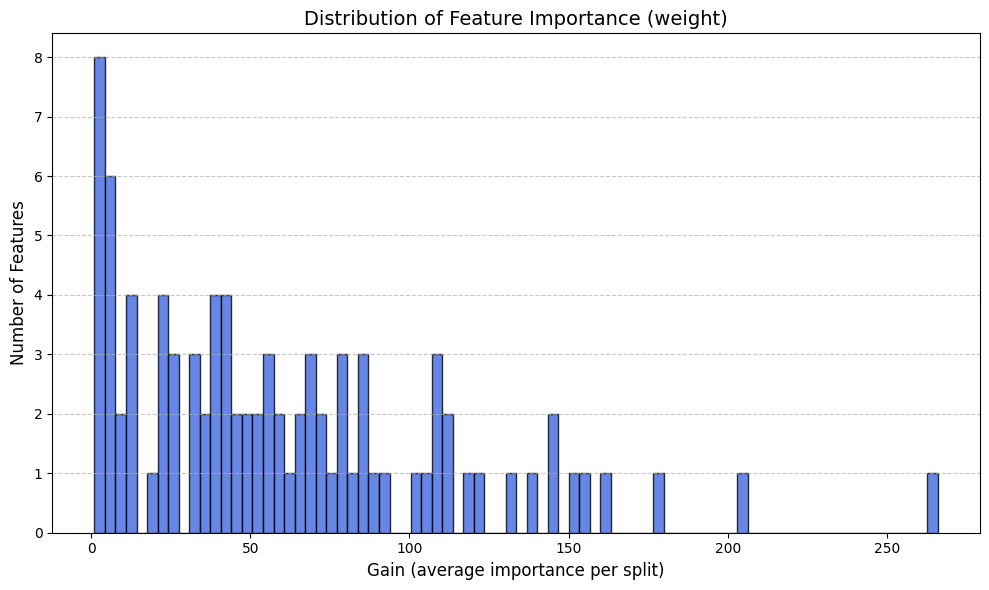

Metric: gain
Top 15 most important features:
                        Feature  Importance
84            health_difference  126.252701
51                 p1_fnt_count   39.880711
42               p2_total_moves   37.585476
41               p1_total_moves   29.483948
49                 p1_slp_count   23.308491
50                 p2_slp_count   21.412233
48            p2_status_changes   19.954613
55                 p1_frz_count   17.970913
56                 p2_frz_count   16.188929
47            p1_status_changes   15.819015
88          remaining_advantage   14.160292
83         p2_remain_health_avg   13.789831
87  p1_hp_advantage_final_ratio   11.973777
33         p2_lead_type_psychic   11.559980
38                  p2_final_hp   10.519099
Least important 10 features:
                      Feature  Importance
46     p2_highcrit_moves_used    5.288043
23                p2_lead_atk    5.240327
43       p1_unique_move_types    5.196055
67            p1_status_moves    5.174744
5           

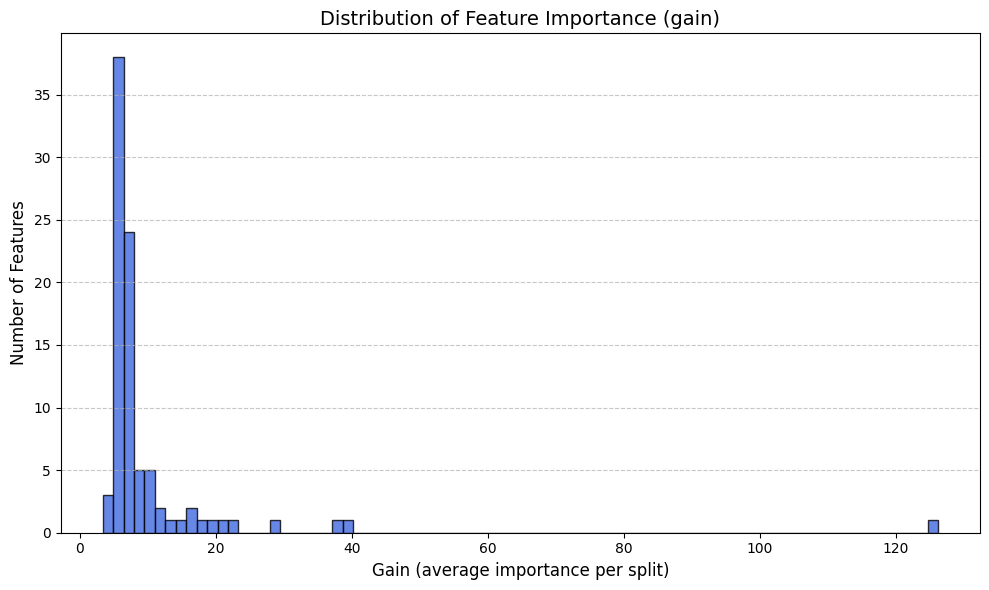

In [625]:
for i in ['weight', 'gain']:

    # We extract the trained booster from the best XGBoost model
    booster = best_xgb.get_booster()
    # We compute feature importance using gain metric
    importance = booster.get_score(importance_type=i)

    temp_features = []
    for k in importance.keys():
        a = k.strip("f")
        temp_features.append(features[int(a)])


    # We convert to DataFrame and sort by the importance
    importance_df = (
        pd.DataFrame({'Feature': temp_features, 'Importance': list(importance.values())})
        .sort_values(by='Importance', ascending=False)
    )

    # Display the top and bottom features
    print("Metric:",i)
    print("Top 15 most important features:")
    print(importance_df.head(15))

    print("Least important 10 features:")
    print(importance_df.tail(10))

    # Plot of the hist
    plt.figure(figsize=(10, 6))
    if k=='gain':
        plt.hist(importance_df['Importance'], bins=100, color='royalblue', edgecolor='black', alpha=0.8)
    else:
        plt.hist(importance_df['Importance'], bins=80, color='royalblue', edgecolor='black', alpha=0.8)     
    plt.title(f'Distribution of Feature Importance ({i})', fontsize=14)
    plt.xlabel('Gain (average importance per split)', fontsize=12)
    plt.ylabel('Number of Features', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Get the ordered list of feature names by importance
    feature_names.append(importance_df['Feature'].tolist())


In [627]:


feature_lists = feature_names

# quantiles in common to remove
quantile = 0.20  
n = len(feature_lists[0])
bottom_n = int(np.ceil(n * quantile))

# Last quantile in sets
bottom_sets = [set(lst[-bottom_n:]) for lst in feature_lists]

# Common features 
common_bottom = set.intersection(*bottom_sets)
print(f"Ultimo {quantile*100:.0f}% = ultimi {bottom_n} elementi per lista\n")
to_drop = list(common_bottom)
print("Candidates to drop:", to_drop)

Ultimo 20% = ultimi 18 elementi per lista

Candidates to drop: ['p2_lead_type_electric', 'p1_min_base_spe', 'p2_highcrit_moves_used', 'p2_lead_type_grass']


In [637]:
not_good=to_drop
not_good.append('battle_id')
not_good.append('player_won')
features = [col for col in train_df.columns if col not in not_good]
X_train = train_df[features]
X_test=test_df[features]
y_train = train_df['player_won']

X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train,train_size=.8, shuffle=True, random_state=seed)


# NEW GRIDSEARCH AND MODELS WITH CHANGED DATA


In [631]:
## GRID SEARCH
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Scaling all the data


model = LogisticRegression(random_state=seed)

param_grid = {
    'C': [0.15, 0.1, 0.05], 
    'penalty': ['l1','l2'],
    'solver': ['liblinear'],
    'max_iter': [10000]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score= True
)

grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")

best_param_lr = grid_search.best_params_
new_logreg=LogisticRegression(**best_param_lr,random_state=seed)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best model mean validation accuracy: 0.8276
 Standard deviation across validation folds: 0.0061
Best hyperparameters found: {'C': 0.15, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy in CV: 0.8276


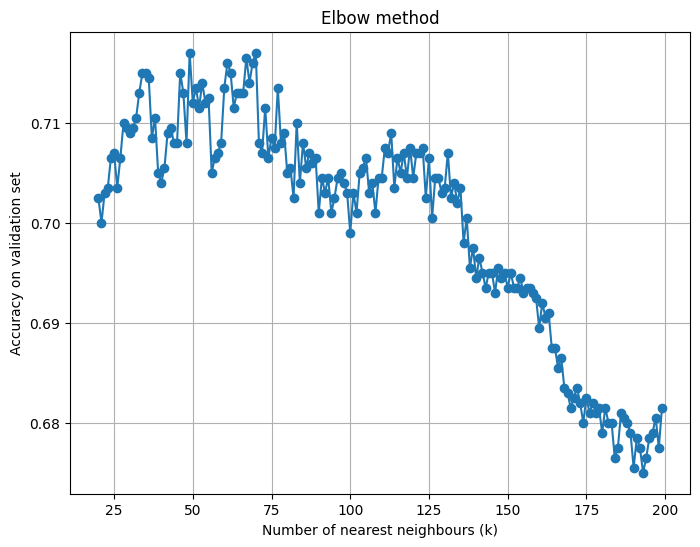

Best k: 49
Accuracy for validation set: 0.7170
 Best model mean validation accuracy: 0.7270
 Standard deviation across validation folds: 0.0088
Best hyperparameters found: {'metric': 'manhattan', 'n_neighbors': 49, 'weights': 'distance'}
Best accuracy in CV: 0.7270


In [641]:

model = KNeighborsClassifier()

k_values = list(range(20,200))
accuracies=[]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_vali)
    acc = accuracy_score(y_vali, y_pred)
    accuracies.append(acc)


plt.figure(figsize=(8,6))
plt.plot(k_values, accuracies, marker='o')
plt.title("Elbow method")
plt.xlabel("Number of nearest neighbours (k)")
plt.ylabel("Accuracy on validation set")
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(accuracies)]
print(f"Best k: {best_k}")
print(f"Accuracy for validation set: {max(accuracies):.4f}")

param_grid = {
    'n_neighbors': [best_k],           
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski','manhattan', 'euclidean'],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=False,
)


grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")

best_param_knn = grid_search.best_params_

In [633]:
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [400, 500, 600],
    'max_depth': [8, 15, 30, 40, 50],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'max_features': ['sqrt'],
    'criterion': ['entropy']
}

# Initialize the base model
rforest = RandomForestClassifier(random_state=seed)

# Set up K-Fold cross-validation (k=5)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Set up the Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=rforest,
    param_grid=param_grid,
    cv=kfold,
    scoring='accuracy',
    n_jobs=-1,       # use all available CPU cores
    verbose=2
)

# Run the grid search
grid_search.fit(X_train, y_train)

# Results
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")

best_param_rf = grid_search.best_params_
new_rf = RandomForestClassifier(**best_param_rf,random_state=seed)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
 Best model mean validation accuracy: 0.8204
 Standard deviation across validation folds: 0.0011
Best hyperparameters found: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}
Best accuracy in CV: 0.8216


In [635]:
# Base XGBoost model
xgb = XGBClassifier(
    random_state=seed,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [400, 500, 600, 900],
    'max_depth': [2, 3, 4],
    'learning_rate': [1, 0.04, 0.03, 0.05],
    'gamma': [0],
    'lambda': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.9]
}

# K-Fold cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=kfold,
    n_jobs=-1,
    verbose=2
)

# Run the grid search
grid_search.fit(X_train, y_train)

# Results
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")
best_param_xgb = grid_search.best_params_

new_xgb = XGBClassifier(**best_param_xgb, random_state=seed)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\franc\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:39:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Best model mean validation accuracy: 0.8344
 Standard deviation across validation folds: 0.0045
Best hyperparameters found: {'colsample_bytree': 0.9, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 600, 'subsample': 0.8}
Best accuracy in CV: 0.8344


In [639]:
# Base learners
estimators = [
    ('rf', new_rf),
    ('xgb', new_xgb),
    ('logreg', new_logreg),
    ('knn', new_knn)
]

# Meta-learner (impara a combinare i modelli)
meta_model2 = LogisticRegression(random_state=seed, max_iter=100000)

# Stacking ensemble
stack2 = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model2,
    passthrough=True 
)

stack2.fit(X_train, y_train)
stck2_accuracy=stack.score(X_vali, y_vali)
print("Stacking accuracy:", stck_accuracy)

c:\Users\franc\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 85 features, but RandomForestClassifier is expecting 89 features as input.

In [ ]:
stck2_accuracy=stack.score(X_vali, y_vali)
print("Stacking accuracy:", stck2_accuracy)

c:\Users\franc\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 85 features, but RandomForestClassifier is expecting 89 features as input.

# DATA SHOWDOWN

In [ ]:
model_dict = {
    "LogisticRegression":[best_logreg, logreg_accuracy],
    "KNN":[best_knn, knn_accuracy],
    "DecisionTree":[best_dt, dt_accuracy],
    "RandomForest":[best_rf, rf_accuracy],
    "XGBoost":[best_xgb, xgb_accuracy],
    "Stacking":[best_stck, stck_accuracy]
    "Stacking with data drop":[stack2, stck2_accuracy]
}

max_acc = 0
best_model = None
print(f"{'Model:':<20} {'Accuracy:'}")
for model_name, model in model_dict.items():
    if model[1] > max_acc:
        best_model = model[0]
        max_acc = model[1]
    print(f"{model_name:<20} {model[1]}")




Model:               Accuracy:
LogisticRegression   0.8445
KNN                  0.8215
DecisionTree         0.796
RandomForest         0.836
XGBoost              0.851
Stacking             0.852


In [ ]:
model_dict = {
    "LogisticRegression":[best_logreg, logreg_accuracy],
    "KNN":[best_knn, knn_accuracy],
    "DecisionTree":[best_dt, dt_accuracy],
    "RandomForest":[best_rf, rf_accuracy],
    "XGBoost":[best_xgb, xgb_accuracy],
    "Stacking":[stack, stck_accuracy]
}

max_acc = 0
best_model = None
print("AFTER CUTTING DATA")
print(f"{'Model:':<20} {'Accuracy:'}")
for model_name, model in model_dict.items():
    if model[1] > max_acc:
        best_model = model[0]
        max_acc = model[1]
    print(f"{model_name:<20} {model[1]}")


Model:               Accuracy
LogisticRegression   0.8295
KNN                  0.814
DecisionTree         0
RandomForest         0.817
XGBoost              0.821
Stacking             0.824

# SUBMISSIONS


In [ ]:
best_model=best_stck
#best_model=best_xgb

In [ ]:
# Testing the prediction on the test set

print("Generating predictions on the test set...")
test_predictions = best_model.predict(X_test)

Generating predictions on the test set...


In [527]:

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'battle_id': test_df['battle_id'],
    'player_won': test_predictions
})
# Save the DataFrame to a .csv file
submission_df.to_csv(output_path, index=False)

print("\n'submission.csv' file created successfully!")


'submission.csv' file created successfully!
